In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
from catalyst.runners import SupervisedRunner
from catalyst.callbacks import AccuracyCallback
from catalyst.utils import set_global_seed
import matplotlib.pyplot as plt
from typing import List, Dict
from sklearn.metrics import plot_confusion_matrix

# internal imports:
from save_all_batch_metrics_callback import SaveAllBatchMetricsCallback
from model import MnistCNN, MnistSoftmaxRegression
from attacks import GradientSignAttacker
from utils import TorchToSklearnClassifierWrapper


config = {
    "seed": 21,

    "data_folder": "data/",
    "logging_folder": "log/",

    "num_epochs": 3,
    "batch_size": 512,

    "weight_decay": 0.001
}


set_global_seed(19)


def load_dataset():
    train_transforms = transforms.Compose(
        [transforms.RandomRotation(degrees=35), transforms.ToTensor()]
    )
    data_folder = config['data_folder']
    train = datasets.MNIST(data_folder, train=True, download=True, transform=train_transforms)
    test = datasets.MNIST(data_folder, train=False, download=True, transform=transforms.ToTensor())
    return train, test


def plot_by_key(logging_list: List[Dict], key, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=[16, 9])
    ax.plot([entry[key] for entry in logging_list], **kwargs)
    return ax


def eval_runner(runner, eval_loader, metric_fn):
    metric_sum = 0
    for x, y in eval_loader:
        out = runner.predict_batch({"features": x})
        metric = metric_fn(y, out["logits"])
        current_batch_size = len(x)
        metric_sum += current_batch_size * metric
    return metric_sum / len(eval_loader.dataset)


def accuracy(y_true, logits):
    y_pred = torch.argmax(logits, dim=-1)
    return (y_true == y_pred).sum().to(torch.float) / len(y_true)


def separate_input_and_label(dataset, x_aggregate_fn=torch.stack, y_aggregate_fn=torch.tensor):
    X = []
    y = []
    for i in range(len(dataset)):
        x_example, y_example = dataset[i]
        X.append(x_example)
        y.append(y_example)
    return x_aggregate_fn(X), y_aggregate_fn(y)


# MNIST softmax regression

In [2]:
train, test = load_dataset()
train_loader = DataLoader(train, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test, batch_size=config["batch_size"])


model = MnistSoftmaxRegression()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=config["weight_decay"])
criterion = torch.nn.CrossEntropyLoss()
logging_list = []
callbacks = [
    AccuracyCallback(num_classes=10),
    SaveAllBatchMetricsCallback(logging_list)
]


runner = SupervisedRunner(model)
runner.train(
    model=model,
    loaders={"train": train_loader},
    optimizer=optimizer,
    criterion=criterion,
    callbacks=callbacks,
    num_epochs=config["num_epochs"],
    logdir=config["logging_folder"]
)

/Users/Dmitrii.Orekhov/anaconda3/envs/ml/lib/python3.8/site-packages/catalyst/experiments/experiment.py:219: UserWarning:

Attention, there is only one dataloader - train

/Users/Dmitrii.Orekhov/anaconda3/envs/ml/lib/python3.8/site-packages/catalyst/callbacks/optimizer.py:140: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629449223/work/torch/csrc/utils/python_arg_parser.cpp:766.)



[2020-10-17 23:41:38,017] 
1/3 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/3 * Epoch 1 (train): accuracy01=0.6610 | accuracy03=0.8701 | accuracy05=0.9335 | loss=1.3433
[2020-10-17 23:41:43,903] 
2/3 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/3 * Epoch 2 (train): accuracy01=0.7922 | accuracy03=0.9435 | accuracy05=0.9790 | loss=0.8011
[2020-10-17 23:41:50,129] 
3/3 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/3 * Epoch 3 (train): accuracy01=0.8150 | accuracy03=0.9517 | accuracy05=0.9830 | loss=0.6790
Top best models:
log/checkpoints/train.3.pth	0.6790


Training curves:

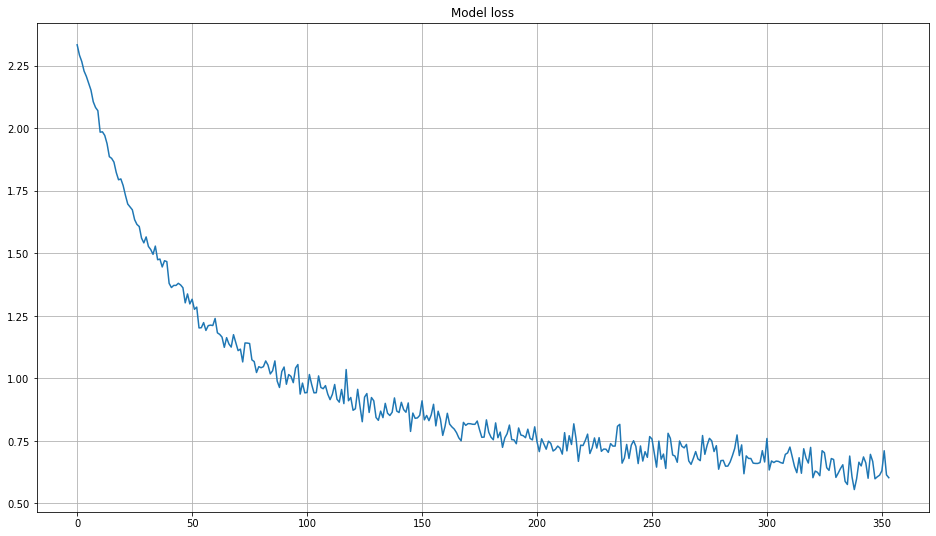

In [3]:
ax = plot_by_key(logging_list, "loss")
ax.set_title("Model loss")
ax.grid()

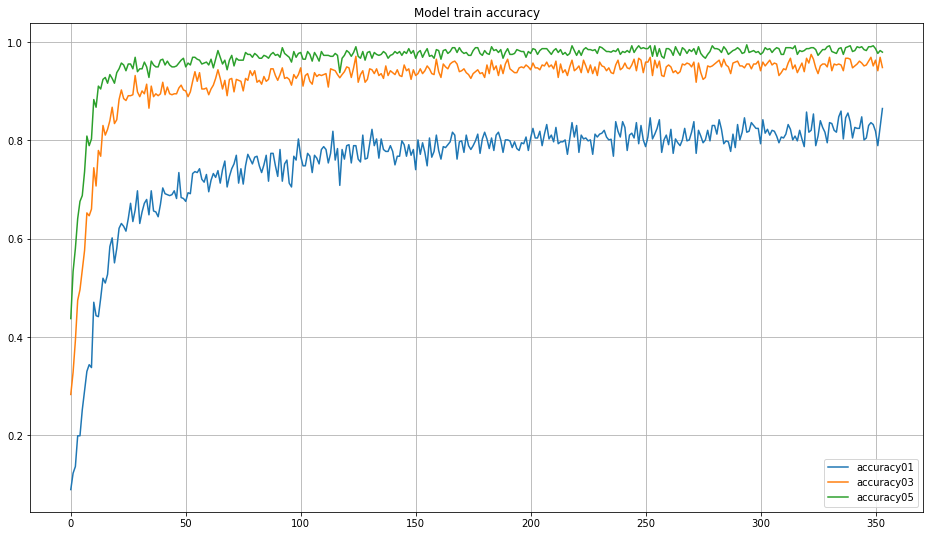

In [4]:
fig, ax = plt.subplots(figsize=[16, 9])
for suff in ["01", "03", "05"]:
    key = f"accuracy{suff}"
    plot_by_key(logging_list, key, ax=ax, label=key)
ax.set_title("Model train accuracy")
ax.legend()
ax.grid()

Evaluating model on test:

In [5]:
test_acc = eval_runner(runner, test_loader, accuracy)
print(f"Test accuracy is {test_acc.item():.3f}")

Test accuracy is 0.870


In [7]:
X_test, y_test = separate_input_and_label(test)
wrapped = TorchToSklearnClassifierWrapper(model)

Confusion matrix for test dataset

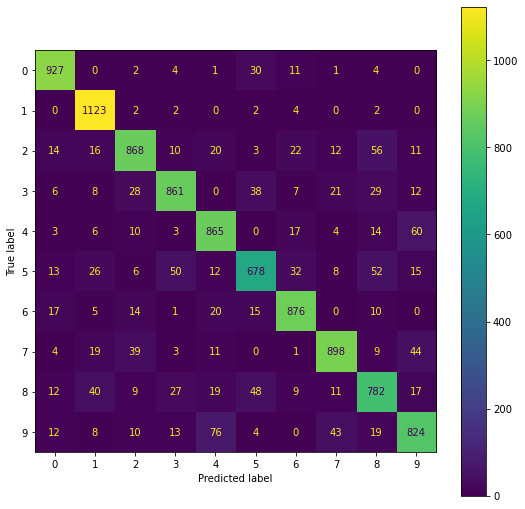

In [8]:
fig, ax = plt.subplots(figsize=[9, 9])
plot_confusion_matrix(wrapped, X_test, y_test, labels=list(range(10)), ax=ax)

## Gradient sign adversarial attack

In [6]:
attacker = GradientSignAttacker(
    model,
    loss_fn=torch.nn.functional.cross_entropy,
    input_shape=[1, 28, 28],
    n_classes=10
)


attacker.fit_adversaries(num_epochs=2000)

Let's produce adversarial examples for every class:

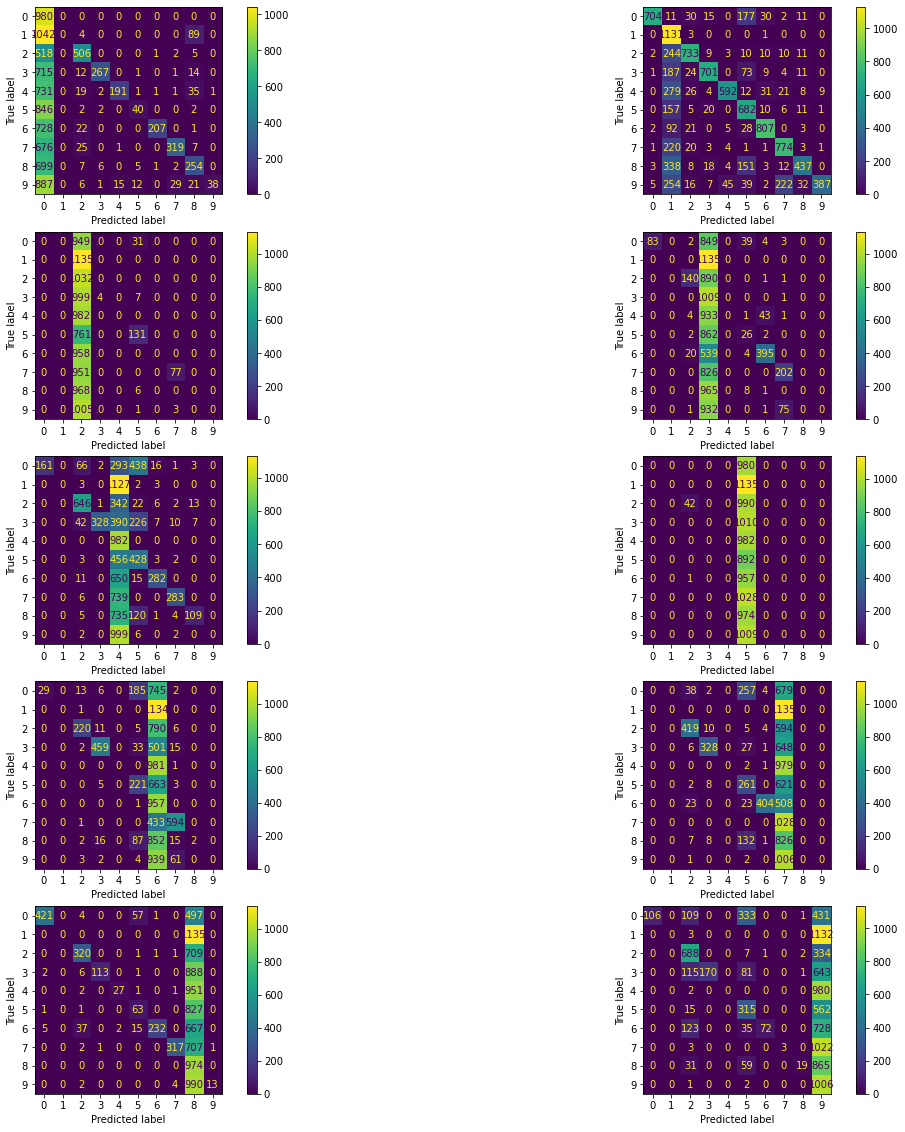

In [30]:
alpha = 0.7 # Weight of the original example in the corrupted sample

nrows, ncols = 5, 2
fig, axes = plt.subplots(figsize=[20, 20], nrows=nrows, ncols=ncols)
for i in range(10):
    row_idx = i // ncols
    col_idx = i % ncols
    ax = axes[row_idx][col_idx]
    corrupted = attacker.attack(X_test, class_idx=i, alpha=alpha)
    plot_confusion_matrix(wrapped, corrupted, y_test, labels=list(range(10)), ax=ax)

This way we can make our model confuse all the examples with a specified class

But the images themselves are still recognizible to human eye

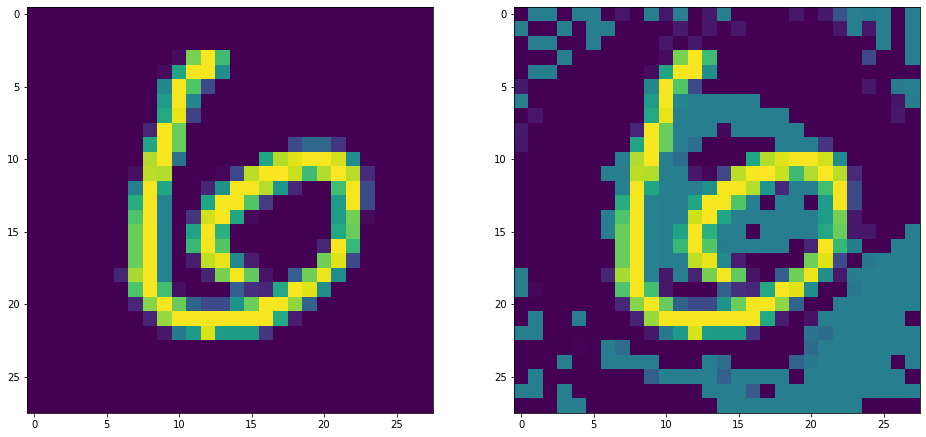

In [34]:
example_idx = 11
fig, axes = plt.subplots(figsize=[16, 8], nrows=1, ncols=2)
axes[0].imshow(X_test[example_idx].squeeze(0))
axes[1].imshow(corrupted[example_idx].squeeze(0).detach())

# Mnist CNN

Let's try to train and attack CNN. This model also relies on batch normalization and dropout (only in fc layers)

In [38]:
model = MnistCNN()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=config["weight_decay"])
criterion = torch.nn.CrossEntropyLoss()
logging_list = []
callbacks = [
    AccuracyCallback(num_classes=10),
    SaveAllBatchMetricsCallback(logging_list)
]


runner = SupervisedRunner(model)
runner.train(
    model=model,
    loaders={"train": train_loader},
    optimizer=optimizer,
    criterion=criterion,
    callbacks=callbacks,
    num_epochs=config["num_epochs"],
    logdir=config["logging_folder"]
)

[2020-10-17 23:57:02,935] 
1/3 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/3 * Epoch 1 (train): accuracy01=0.9122 | accuracy03=0.9738 | accuracy05=0.9884 | loss=0.3951
[2020-10-17 23:57:32,771] 
2/3 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/3 * Epoch 2 (train): accuracy01=0.9723 | accuracy03=0.9970 | accuracy05=0.9992 | loss=0.1056
[2020-10-17 23:58:02,698] 
3/3 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/3 * Epoch 3 (train): accuracy01=0.9786 | accuracy03=0.9981 | accuracy05=0.9996 | loss=0.0771
Top best models:
log/checkpoints/train.3.pth	0.0771


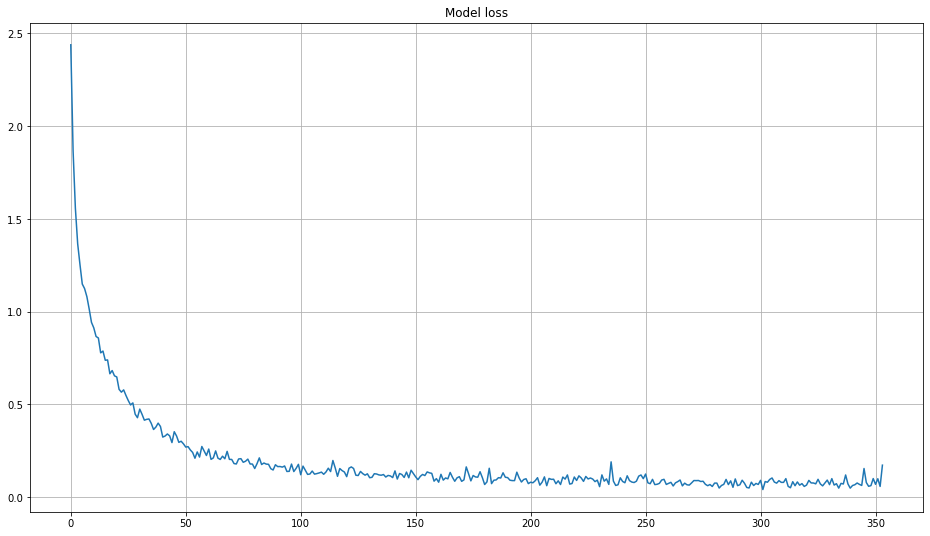

In [39]:
ax = plot_by_key(logging_list, "loss")
ax.set_title("Model loss")
ax.grid()

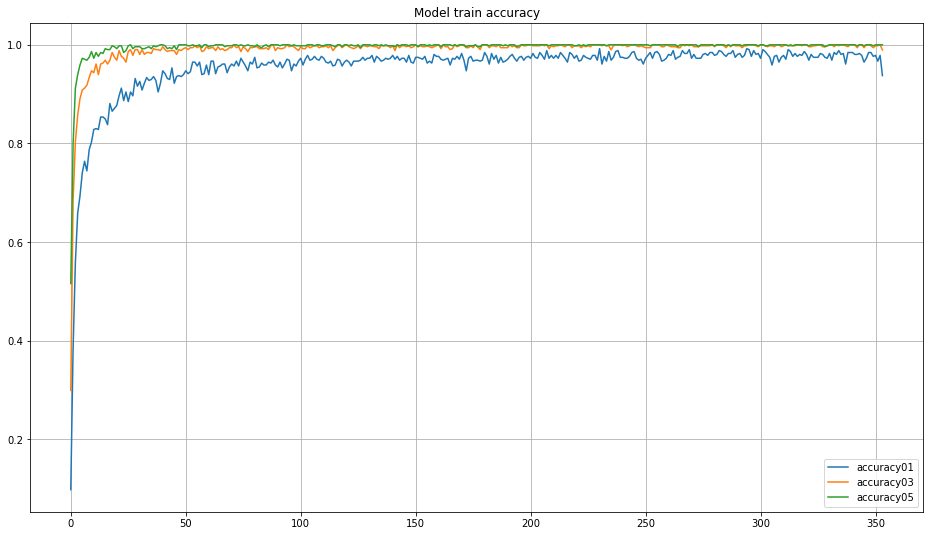

In [40]:
fig, ax = plt.subplots(figsize=[16, 9])
for suff in ["01", "03", "05"]:
    key = f"accuracy{suff}"
    plot_by_key(logging_list, key, ax=ax, label=key)
ax.set_title("Model train accuracy")
ax.legend()
ax.grid()

In [44]:
test_acc = eval_runner(runner, test_loader, accuracy)
print(f"Test accuracy is {test_acc.item():.3f}")

Test accuracy is 0.987


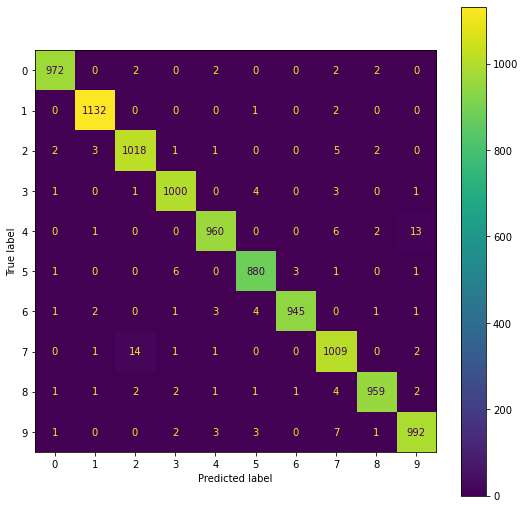

In [46]:
fig, ax = plt.subplots(figsize=[9, 9])
plot_confusion_matrix(wrapped, X_test, y_test, labels=list(range(10)), ax=ax)

In [45]:
attacker = GradientSignAttacker(
    model,
    loss_fn=torch.nn.functional.cross_entropy,
    input_shape=[1, 28, 28],
    n_classes=10
)


attacker.fit_adversaries(num_epochs=5000) # More epochs are needed to generate good adverserial examples

wrapped = TorchToSklearnClassifierWrapper(model)

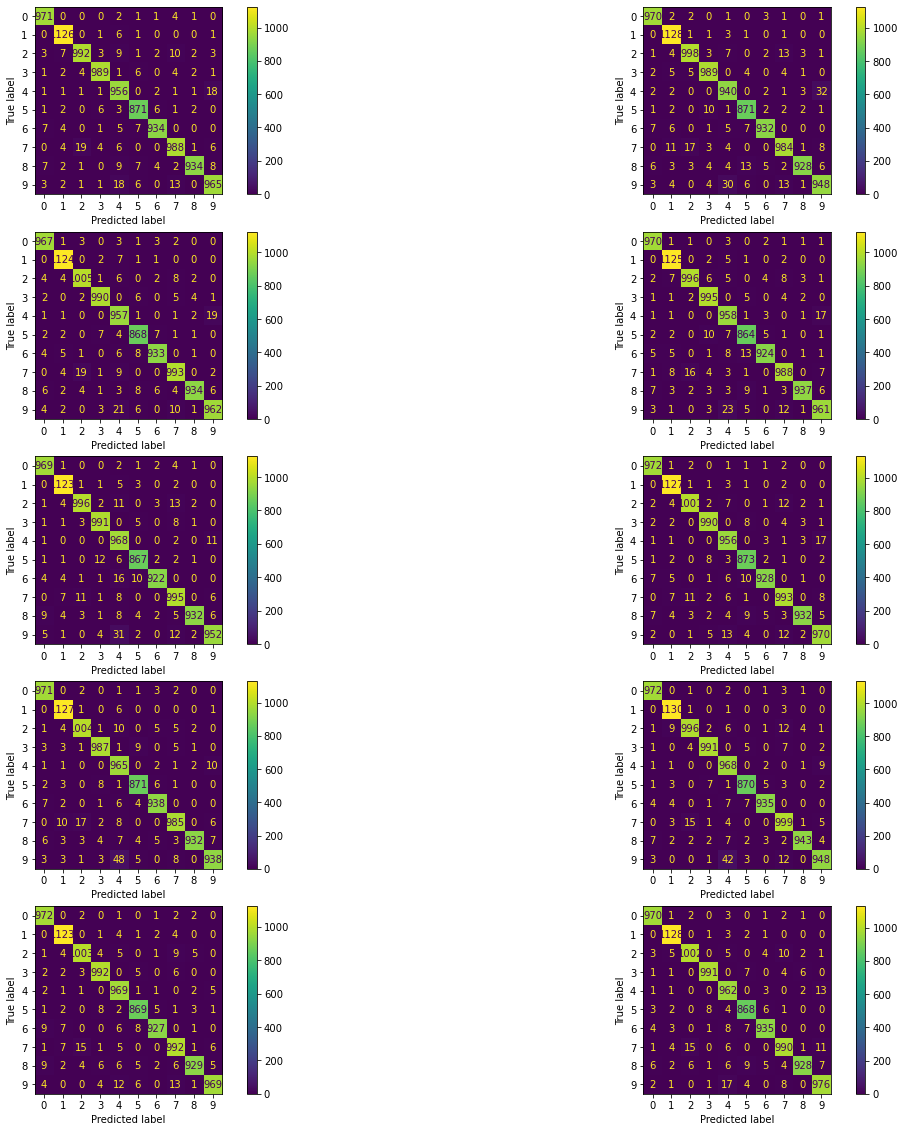

In [47]:
alpha = 0.7 # Weight of the original example in the corrupted sample

nrows, ncols = 5, 2
fig, axes = plt.subplots(figsize=[20, 20], nrows=nrows, ncols=ncols)
for i in range(10):
    row_idx = i // ncols
    col_idx = i % ncols
    ax = axes[row_idx][col_idx]
    corrupted = attacker.attack(X_test, class_idx=i, alpha=alpha)
    plot_confusion_matrix(wrapped, corrupted, y_test, labels=list(range(10)), ax=ax)

CNN with strong regulariation turned out to be much more resilient to adversarial attacks than shallow model.